<center><a href="https://5loi.com/about_loi"><img src="images/DLI_Header.png" width="400" height="186" /></a></center>

# 4a. 数据增强
目前为止，我们已经选择了一个出色的模型架构，此架构的设计目的在于识别图像中的重要特征，因而它极大提高了模型的性能。我们的验证准确率仍落后于训练准确率，这意味着我们有点过拟合。换个角度来看，我们的模型在对验证数据集进行测试时，会因之前从未见过的内容而产生混淆。


为了增强模型在处理新数据时的鲁棒性，我们将以编程方式增加数据集的大小和差异。这称为[*数据增强*](https://link.springer.com/article/10.1186/s40537-019-0197-0)，是对很多深度学习应用都非常有用的技术。

数据的增加让模型在训练时能看到更多图像。数据差异的增加可帮助模型忽略不重要的特征，而只选择在分类时真正重要的特征。如此一来，在面对新数据时，模型有望在进行预测时更好地泛化。

## 4a.1 目标

完成这一章节，您将能够：
* 增强 ASL 数据集
* 使用增强数据来训练改进的模型
* 将训练好的模型保存到磁盘，以进行部署

In [1]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 4a.2 数据准备
我们目前在使用新的 notebook，因此需要重新加载和处理数据。为此，请执行以下单元。

In [2]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

## 4a.3 创建模型

我们还需要再次创建我们的模型。正如我们在上一课中学到的，卷积神经网络使用重复的层序列。让我们利用这种模式来创建我们自己的[自定义模块](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html)。然后就可以在我们的 [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) 模型中像使用层一样使用这个模块。

为此，我们将扩展 [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) 类。定义两个方法：
* `__init__`：定义我们希望模块拥有的任何属性，包括神经网络层。实际上是在模型中使用另一个模型。
* `forward`：定义我们希望模块如何处理来自它所连接的前一层的任何输入数据。由于我们用的是 `Sequential` 模型，可以像进行预测一样将输入数据传入其中。

In [3]:
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

现在我们已经定义了我们的自定义模块，让我们看看它的实际应用。下面的模型在架构上与上一课中的相同。你能看出联系吗？

In [4]:
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

当我们打印模型时，它不仅会显示我们自定义模块的使用，还会显示我们自定义模块内的层：

In [5]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

model = torch.compile(base_model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affin

自定义模块是灵活的，我们可以定义任何我们希望拥有的其它方法或属性。这使得它们在数据科学家试图解决复杂问题时变得非常强大。

## 4a.4 数据增强

在定义训练循环之前，是时候进行数据增强了。

我们之前见过 [TorchVision](https://pytorch.org/vision/stable/index.html) 的 [Transforms](https://pytorch.org/vision/0.9/transforms.html)，但在本课中，我们将进一步探索它的数据增强工具。首先，让我们获取一个用于测试的样本图像：

In [6]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

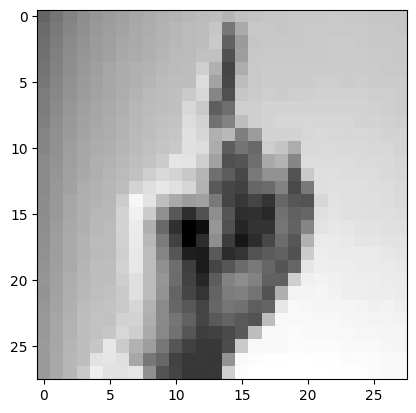

In [7]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

### 4a.4.1 [RandomResizeCrop](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomResizedCrop)

这个变换将根据 `scale` 随机调整输入图像的大小，然后将其[裁剪（crop）](https://en.wikipedia.org/wiki/Cropping_(image))到我们指定的大小。在本例中，我们将其裁剪到原始图像尺寸。为此，TorchVision 需要知道它所缩放图像的[长宽比](https://en.wikipedia.org/wiki/Aspect_ratio_(image))。由于这里的高度与宽度相同，因此宽高比为 1:1。

In [8]:
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])

尝试多次运行下面的单元，每次结果都应该不同。

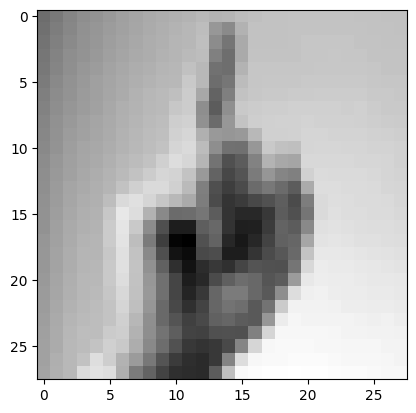

In [9]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [10]:
new_x_0.shape

torch.Size([1, 28, 28])

### 4a.4.2 [RandomHorizontalFlip](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip)

我们还可以随机地水平或垂直翻转我们的图像。然而，对于这些图像，我们只会水平翻转它们。

花点时间思考一下为什么我们想要水平翻转图像，而不是垂直翻转。当你有了想法后，查看下面的文字。

`# SOLUTION`
我们的数据集由表示字母表的手部图片组成。如果以后要使用此模型对手部图像进行分类时，这些手是不可能上下倒置的，但他们可能是左撇子。这种特定领域的推理可以帮助您为自己的深度学习应用做出正确的决策。

In [11]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

尝试多次运行下面的单元格。图像是否大约有一半的时间会翻转？

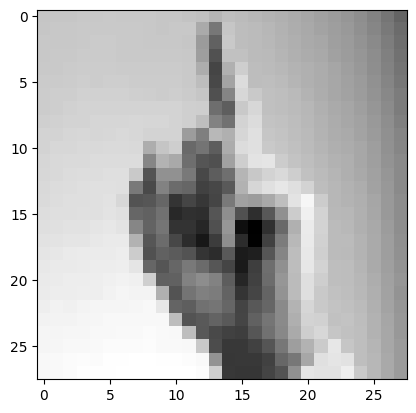

In [12]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [RandomRotation](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomRotation)

我们还可以随机旋转图像以增加更多变化。就像其他增强技术一样，很容易不小心做得过头。对于美国手语来说，如果我们旋转得太多，`D` 可能会像 `G`，反之亦然。因此，让我们将其限制在 `30` 度以内。

In [13]:
trans = transforms.Compose([
    transforms.RandomRotation(10)
])

当我们运行下面的代码块时，可能会出现一些黑色像素。当我们旋转时，图像的角落会消失，几乎每失去一个像素，我们就会得到一个空白像素。

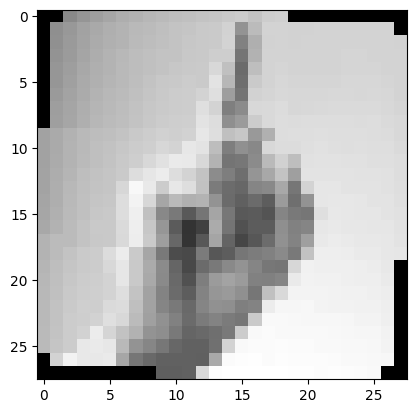

In [14]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [ColorJitter](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.ColorJitter)

`ColorJitter` 变换有 4 个参数：
* [brightness](https://en.wikipedia.org/wiki/Brightness)
* [contrast](https://en.wikipedia.org/wiki/Contrast_(vision))
* [saturation](https://en.wikipedia.org/wiki/Colorfulness#Saturation)
* [hue](https://en.wikipedia.org/wiki/Hue)


后两个适用于彩色图像，所以我们现在只需要前两个。

In [15]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

尝试多次运行下面的代码，但也试着将 `brightness` 或 `contrast` 改为 `1`。有得到任何有趣的结果吗？

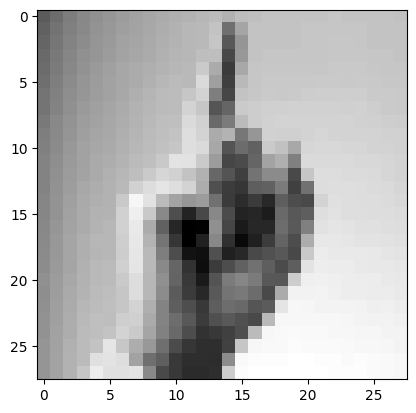

In [16]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.3.4 [Compose](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose)

是时候把所有内容整合在一起了。我们可以使用 `Compose` 创建这些随机变换的序列。

In [17]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

让我们测试一下。有了所有这些不同的组合，这一张图像有多少种变化？无限种吗？

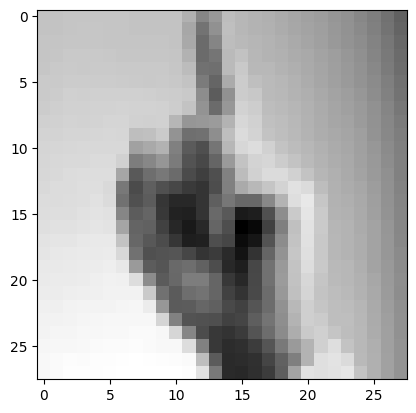

In [18]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4 用增强的数据进行训练

训练过程大部分保持不变，但有一行发生了变化。在将图像传递给模型之前，我们将应用 `random_transforms`。为了方便起见，将 `get_batch_accuracy` 移到了 [utils](./utils.py) 文件中。

In [19]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

另一方面，验证过程保持不变。没有随机变换。

In [20]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

来测试一下图像增强。

In [21]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 658.6715 Accuracy: 0.7532
Valid - Loss: 113.0675 Accuracy: 0.8087
Epoch: 1
Train - Loss: 104.9473 Accuracy: 0.9612
Valid - Loss: 26.6538 Accuracy: 0.9619
Epoch: 2
Train - Loss: 52.8951 Accuracy: 0.9801
Valid - Loss: 28.6945 Accuracy: 0.9541
Epoch: 3
Train - Loss: 45.0715 Accuracy: 0.9832
Valid - Loss: 21.9441 Accuracy: 0.9661
Epoch: 4
Train - Loss: 33.2140 Accuracy: 0.9871
Valid - Loss: 19.2223 Accuracy: 0.9767
Epoch: 5
Train - Loss: 27.9107 Accuracy: 0.9892
Valid - Loss: 38.8061 Accuracy: 0.9354
Epoch: 6
Train - Loss: 28.6344 Accuracy: 0.9887
Valid - Loss: 19.8784 Accuracy: 0.9734
Epoch: 7
Train - Loss: 23.8072 Accuracy: 0.9910
Valid - Loss: 9.7214 Accuracy: 0.9845
Epoch: 8
Train - Loss: 20.7405 Accuracy: 0.9921
Valid - Loss: 8.0440 Accuracy: 0.9863
Epoch: 9
Train - Loss: 20.1238 Accuracy: 0.9925
Valid - Loss: 20.4119 Accuracy: 0.9801
Epoch: 10
Train - Loss: 17.4593 Accuracy: 0.9932
Valid - Loss: 12.5699 Accuracy: 0.9822
Epoch: 11
Train - Loss: 19.1432 Accuracy:

## 4a.5 讨论获得的结果
您会注意到验证准确率更高且更一致，这意味着我们的模型已摆脱过拟合问题。现在它具有更好的泛化能力，因而能够更好地对新数据作出预测。

训练准确率可能会降低，这是可以接受的。与之前相比，模型现在接触到了更加多样化的数据。

## 4a.6 保存模型
现在我们已对模型进行了有效训练，下面我们就来实际应用它吧！让我们使用该模型对新图像进行分类，此过程称为推理。而在程序中使用训练过的模型则称为部署。第一步最好先将模型保存到磁盘上。然后，您可将模型传给应用该模型的各种环境中并加载。

PyTorch 有[多种方式](https://pytorch.org/tutorials/beginner/saving_loading_models.html)可以做到这一点，这里要用的是 `torch.save`。我们还需要保存自定义的模块代码 `MyConvBlock`，已经在 [utils.py](./utils.py) 中保存了。在下一个 notebook 中，我们将加载模型并用它来读取新的手语图片。

PyTorch 无法保存编译后的模型（[参见这个帖子](https://discuss.pytorch.org/t/how-to-save-load-a-model-with-torch-compile/179739)），所以我们将采用其它方式。

In [22]:
torch.save(base_model, 'model.pth')

## 4a.7 总结

在本节中，您使用 TorchVision 增强了数据集，结果是经过训练的模型，具有较少的过拟合和出色的测试图像结果。

### 4a.7.1 清理显存
继续进行后面的内容前，请执行以下单元以清理 GPU 显存。

In [23]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 4a.7.2 下一步

现在，您已经过有效训练的模型保存到磁盘，在下一部分中，您将部署模型以对从未看到过的图像进行预测。